# Slate Star Codex Reader Survey 2018

**If you enjoy this, let's connect on LinkedIn:**

**https://www.linkedin.com/in/vincefavilla/**

I'm a psychology professor and machine learning engineer. Also, I'm in the SF Bay Area and looking for a job outside of academia. :)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

from warnings import filterwarnings
filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


After some experimenting, I decided that it's better to analyze the data where I inferred the missing values using machine learning. This obviously isn't perfect, and we can't be certain what someone *would have* answered, but we can more accurately represent individual differences this way.

In [349]:
data = pd.read_csv('ssc2018public_inferred.csv')

data = data[[i for i in data.columns if 'Unnamed' not in i]]
# Removing some bad data I spotted
data = data[data['CRT2'] < 100]
data = data[data['CRT1'] < 10000]
data = data[data['Gender2M'] < 300]

print('Data has', data.shape[0], 'responses and', data.shape[1], 'features')

Data has 7260 responses and 838 features


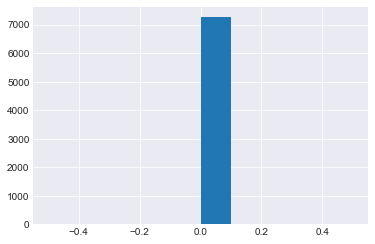

In [350]:
data['Num_missing'] = data.isnull().sum(axis=1)

data['Num_missing'].hist()

data = data[data.Num_missing < 20]

# Demographics

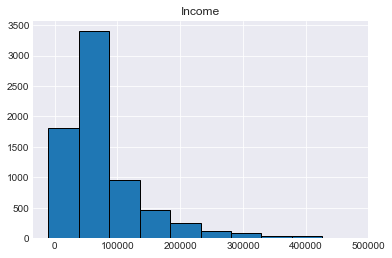

In [351]:
# Income
data[data.Income < 500000].Income.hist(edgecolor='black') # Remove the millionaire outliers
plt.title('Income')

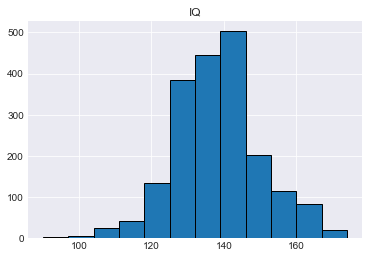

In [352]:
# IQ
data[data.IQ != data.IQ.median()].IQ.hist(edgecolor='black', bins=12)

plt.title('IQ')

We can normalize the SAT scores to account for which version of the test people took. We have a lot of really smart people in this community.

As a side note, whenever you see code along the lines of `!= .median()`, it means I'm removing the missing data I couldn't reasonably predict.

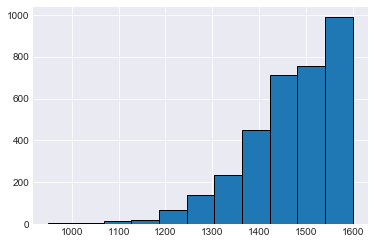

In [353]:
sat = np.where(data.SATscoresoutof1600 != data.SATscoresoutof1600.median(), data.SATscoresoutof1600/1600, np.nan)
sat = np.where(data.SATscoresoutof2400 != data.SATscoresoutof2400.median(), data.SATscoresoutof2400/2400, sat)

sat = pd.Series(sat) * 1600

sat[sat > 900].hist(edgecolor='black', bins=11)

One of my favorite things about the rationalist community is we tend to assume we're average unless we have strong evidence otherwise...

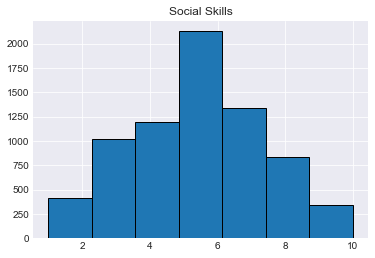

In [354]:
data.SocialSkills.hist(edgecolor='black', bins=7)
plt.title('Social Skills')

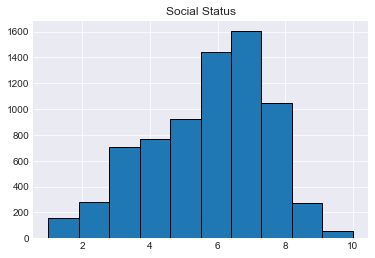

In [355]:
data.Status.hist(edgecolor='black', bins=10)
plt.title('Social Status')

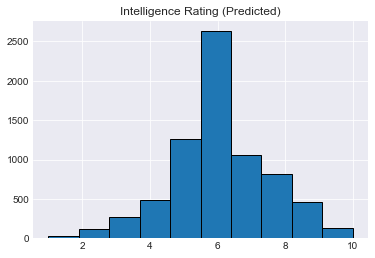

In [356]:
# "How intelligent do you think you are compared to the average reader of this blog?"
data.Percentile.hist(edgecolor='black', bins=10)
# I replaced missing values with the median -- and kept it -- 
# so this graph is a little more peaky than the others.

plt.title('Intelligence Rating (Predicted)')

Let's graph IQ vs. how people think they stack up against fellow SSC readers.

Correlation: 0.254


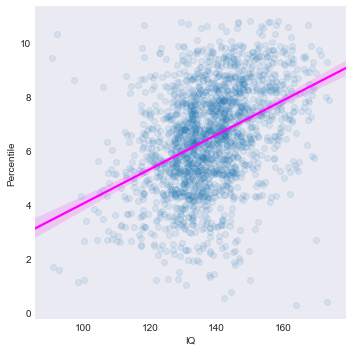

In [357]:
print('Correlation:', round(np.corrcoef(data.Percentile, data.IQ)[0,1], 3))

sns.lmplot('IQ', 'Percentile', data=data[data.IQ != data.IQ.median()],
            y_jitter=.9, x_jitter=3, scatter_kws={'alpha':.1}, line_kws={'color': 'magenta'})

The Dunning-Kruger effect is in full force in the top left. They're probably trolls. There are also a handful of very underconfident geniuses.

The relationship between IQ and social status is not as pronounced...

Correlation: 0.105


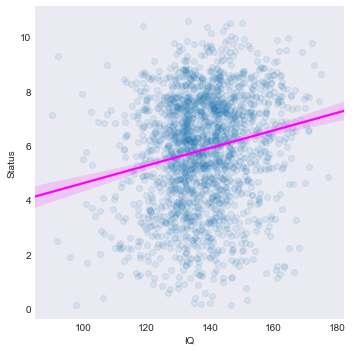

In [358]:
print('Correlation:', round(np.corrcoef(data.Status, data.IQ)[0,1], 3))

sns.lmplot('IQ', 'Status', data=data[data.IQ != data.IQ.median()],
            y_jitter=.9, x_jitter=3, scatter_kws={'alpha':.1}, line_kws={'color': 'magenta'})

# Life Outcomes

Let's look at the correlates for:

- RomanticLife
- FinancialSituation & Income
- LifeSatisfaction & MoodScale

The usual warning of correlation does not equal causation applies.

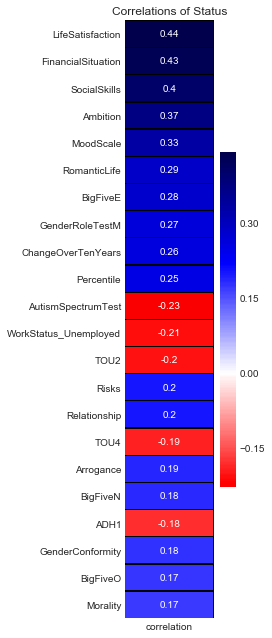

In [359]:
def absolute_correlations(col, df=data, ascending=False):
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    if ascending == False:
        return corrs.sort_values('absol', ascending=ascending).drop('absol', axis=1).tail(len(corrs)-1)
    else:
        return corrs.sort_values('absol', ascending=ascending).drop('absol', axis=1).head(len(corrs)-1)

def corrmap(df, cutoff=0.2, title='Correlations'):
    top_corrs = df[abs(df.correlation) > cutoff]
    plt.figure(figsize=(2,len(top_corrs)//2))
    plt.title(title)
    sns.heatmap(top_corrs, annot=True, fmt='.2g', cmap='seismic_r',
                center=0, linecolor='black', linewidths=.25)

# Status
status = absolute_correlations('Status', ascending=False)
corrmap(status, cutoff=.17, title='Correlations of Status')

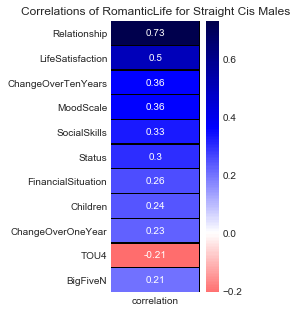

In [360]:
# Romantic life for straight cis males
scm = data[(data['Gender_M (cisgender)'] == 1) & (data['SexualOrientation_Heterosexual']) & (data['Sex_Male'] == 1)]

status = absolute_correlations('RomanticLife', df=scm, ascending=False)
corrmap(status, cutoff=.20, title='Correlations of RomanticLife for Straight Cis Males')

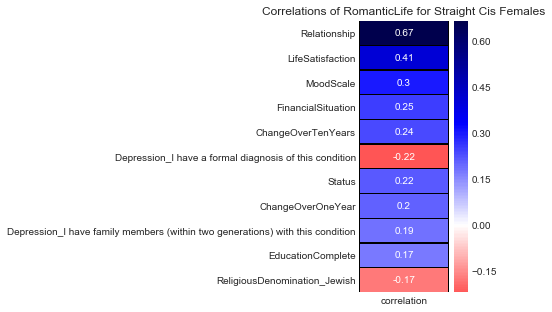

In [361]:
# Romantic life for straight cis females
scf = data[(data['Gender_F (cisgender)'] == 1) & data['SexualOrientation_Heterosexual'] & (data['Sex_Female'] == 1)]

status = absolute_correlations('RomanticLife', df=scf, ascending=False)
corrmap(status, cutoff=.17, title='Correlations of RomanticLife for Straight Cis Females')

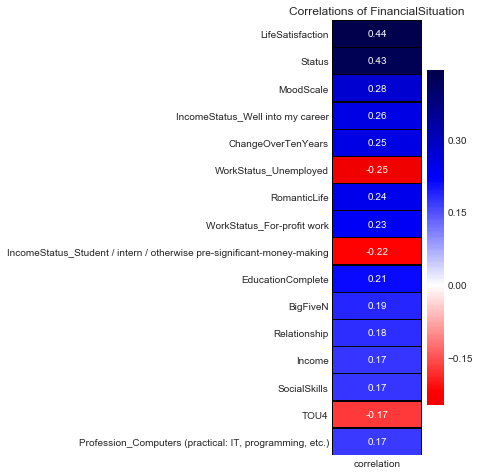

In [362]:
# FinancialSituation
finances = absolute_correlations('FinancialSituation', ascending=False)
corrmap(finances, cutoff=.17, title='Correlations of FinancialSituation')

C:\Users\Vince\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in log1p


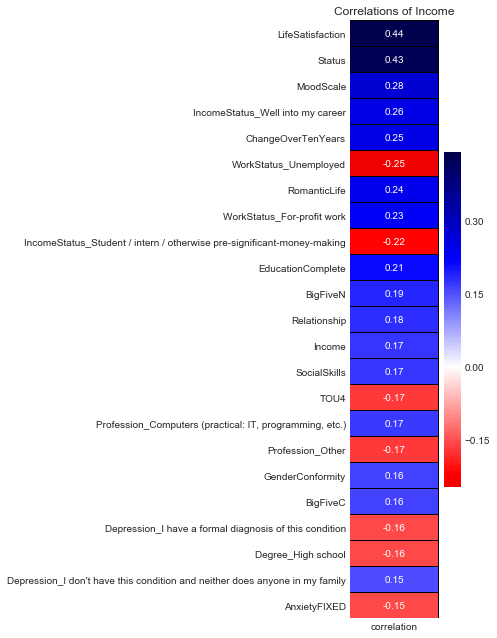

In [495]:
# Income

# This is a power law distribution so we should take the log
data['Log_income'] = np.log1p(data['Income'])

income = absolute_correlations('Log_income', df=data, ascending=False)
corrmap(finances, cutoff=.15, title='Correlations of Income')

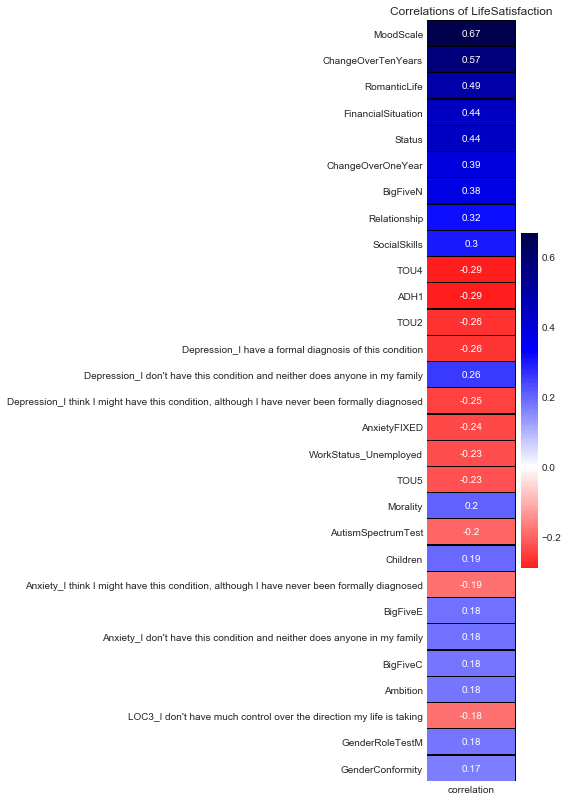

In [364]:
# LifeSatisfaction
satisfaction = absolute_correlations('LifeSatisfaction', ascending=False)
corrmap(satisfaction, cutoff=.17, title='Correlations of LifeSatisfaction')

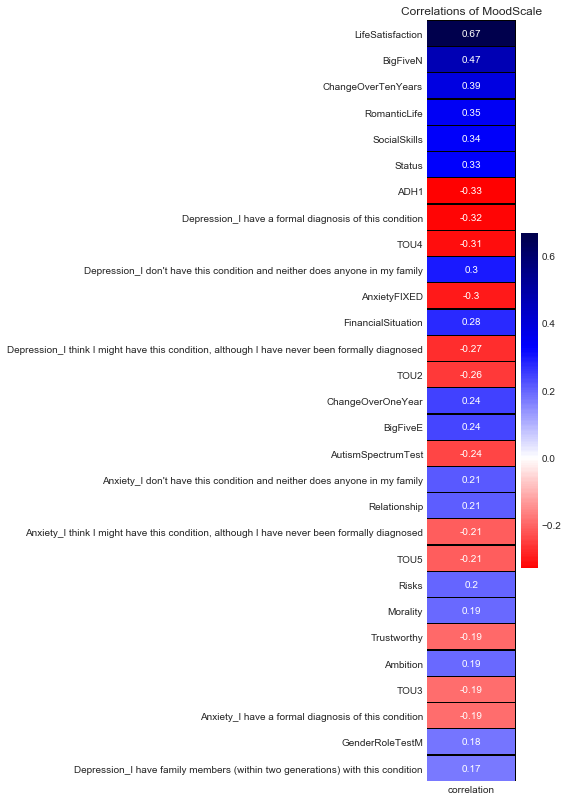

In [365]:
# MoodScale
mood = absolute_correlations('MoodScale', ascending=False)
corrmap(mood, cutoff=.17, title='Correlations of MoodScale')

There's something very odd here that I can't explain. Neuroticism is strongly correlated with MoodScale, but neuroticism is essentially synonymous with depression (I explain the difference as neuroticism is a stable personality trait, while depression is a diagnosis that comes and goes. But it's fundamentally the same thing.).

I don't know why we're seeing this. However, we do see other, more logical predictors of mood, including social status, romantic life, and social skills.

# Personality

I think kdeplots look a bit better than histograms for graphing the big five personality traits. The distributions are a bit wonky, but a kdeplot can smooth them out and give us a better idea of what the population probably looks like.

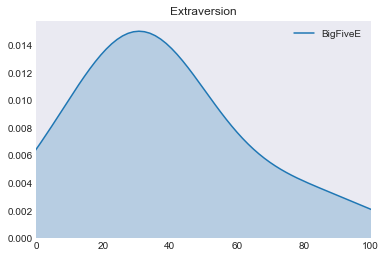

In [366]:
sns.kdeplot(data.BigFiveE, bw=18, shade=True)
plt.xlim(0,100)
plt.title('Extraversion')

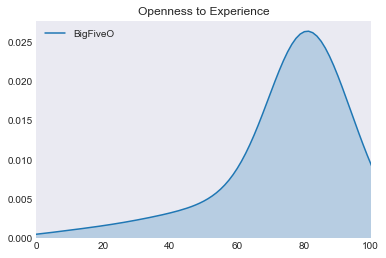

In [367]:
sns.kdeplot(data.BigFiveO, bw=10, shade=True)
plt.xlim(0,100)
plt.title('Openness to Experience')

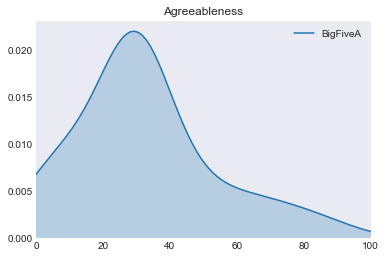

In [368]:
sns.kdeplot(data.BigFiveA, bw=10, shade=True)
plt.xlim(0,100)
plt.title('Agreeableness')

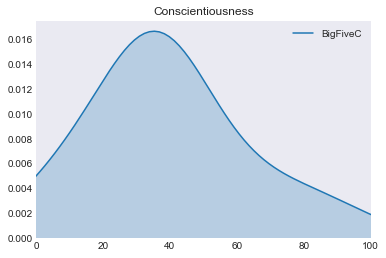

In [369]:
sns.kdeplot(data.BigFiveC, bw=15, shade=True)
plt.xlim(0,100)
plt.title('Conscientiousness')

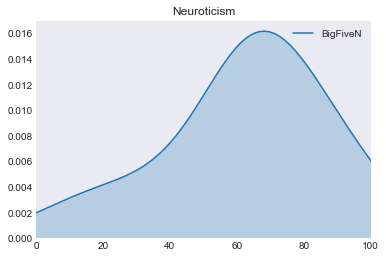

In [370]:
sns.kdeplot(data.BigFiveN, bw=15, shade=True)
plt.xlim(0,100)
plt.title('Neuroticism')

# Religion

I've done a lot of religious/geographic analysis in the past and it's usually not that interesting because the differences tend to be pretty small. This dataset is no exception, but I'll include it since I'm sure lots of people are curious.

In [371]:
# For this analysis, it's better to not use inferred values
data = pd.read_csv('ssc2018public_cleaned.csv')

data = data[[i for i in data.columns if 'Unnamed' not in i]]
data = data[data['CRT2'] < 100]
data = data[data['CRT1'] < 10000]
data = data[data['Gender2M'] < 300]

In [372]:
rels = data[[i for i in data.columns if "Denom" in i]].copy()

atheists = data[[i for i in data.columns if 'Ath' in i and 'but spiritual' not in i]].sum(axis=1)
rels['ReligiousDenomination_Atheist'] = pd.Series(np.where(atheists >= 1, 1., 0)).copy()
rels['ReligiousDenomination_Other'] = pd.Series(np.where(atheists >= 1, 0, rels['ReligiousDenomination_Other'])).copy()

rels = rels.idxmax(axis=1)

rels_vcs = rels.value_counts()
rels_vcs = rels_vcs[rels_vcs > 10]

rels = np.where(rels.isin(rels_vcs.index), rels, 'ReligiousDenomination_Other')

data['Religion_categorial'] = pd.Series(rels)

data['Religion_categorial'].value_counts()

ReligiousDenomination_Atheist                                                  4007
ReligiousDenomination_Other                                                    1554
ReligiousDenomination_Christian (Protestant)                                    634
ReligiousDenomination_Christian (Catholic)                                      362
ReligiousDenomination_Jewish                                                    213
ReligiousDenomination_Buddhist                                                  113
ReligiousDenomination_Mixed/Other                                               107
ReligiousDenomination_Unitarian Universalism Or Similar                          82
ReligiousDenomination_Christian (Other Non-Protestant, Eg Eastern Orthodox)      72
ReligiousDenomination_Christian (Mormon)                                         53
ReligiousDenomination_Hindu                                                      41
ReligiousDenomination_Muslim                                                

The average life satisfaction of different religions...

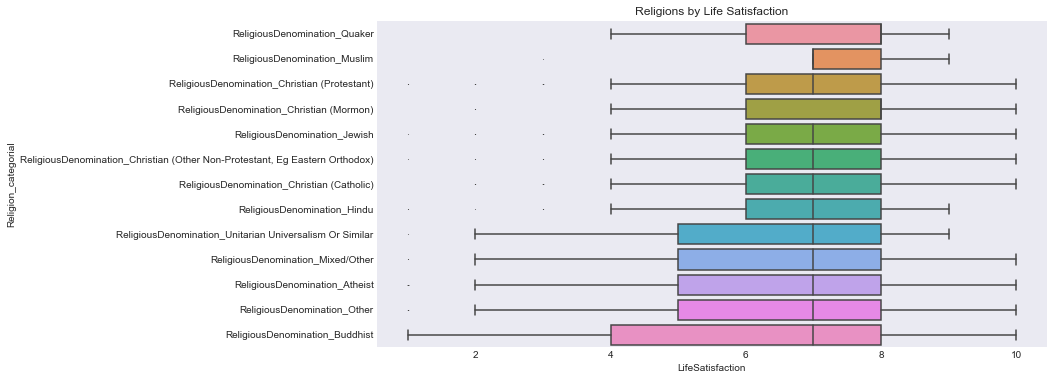

In [424]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').mean()['LifeSatisfaction'].sort_values(ascending=False).index
sns.boxplot(data['LifeSatisfaction'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Life Satisfaction')

In [433]:
# Comparing life satisfaction with a t-test
from scipy.stats import ttest_ind

def compare_top_and_bottom(col, order, top=0, bot=-1):
    df = data[data[col].notnull()]
    top_ix = order[top]
    bot_ix = order[bot]
    by = order.name
    
    if top == 0 and bot == -1:
        print('Highest ' + col + ': ' + top_ix)
        print('Lowest ' + col + ': ' + bot_ix)
    else:
        print('Comparing {} and {}'.format(top_ix, bot_ix))
    
    ttest = ttest_ind(df[df[by] == top_ix][col],
                      df[df[by] == bot_ix][col])
    return ttest
    
compare_top_and_bottom('LifeSatisfaction', order)

Highest LifeSatisfaction: ReligiousDenomination_Muslim
Lowest LifeSatisfaction: ReligiousDenomination_Atheist


Ttest_indResult(statistic=1.1645272801825115, pvalue=0.24428115152077681)

There is **not** a statistically significant difference between the happiest religion (Quakers) and the unhappiest (Buddhists). I expected this, since Buddhists usually place first in happiness in other datasets I've looked at.

### Religions by Extraversion

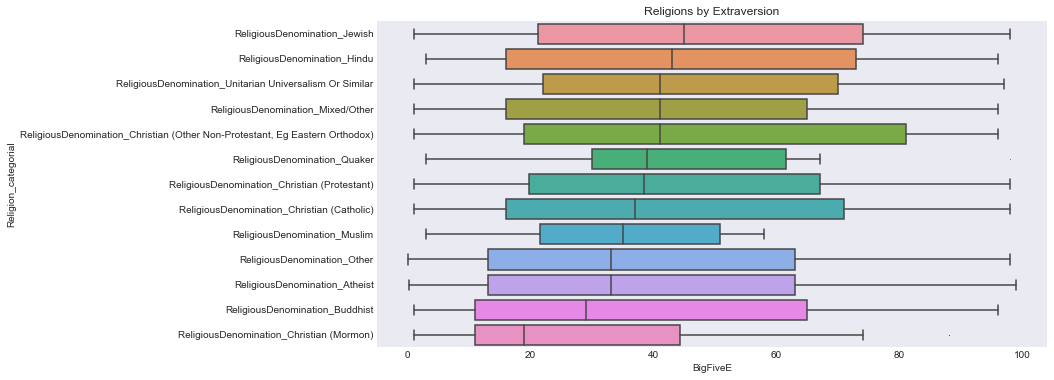

In [434]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveE'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveE'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Extraversion')

In [435]:
# Statistically significant
compare_top_and_bottom('BigFiveE', order)

Highest BigFiveE: ReligiousDenomination_Jewish
Lowest BigFiveE: ReligiousDenomination_Christian (Mormon)


Ttest_indResult(statistic=2.9761467858892279, pvalue=0.0034478008717579072)

### Religions by Openness to Experience

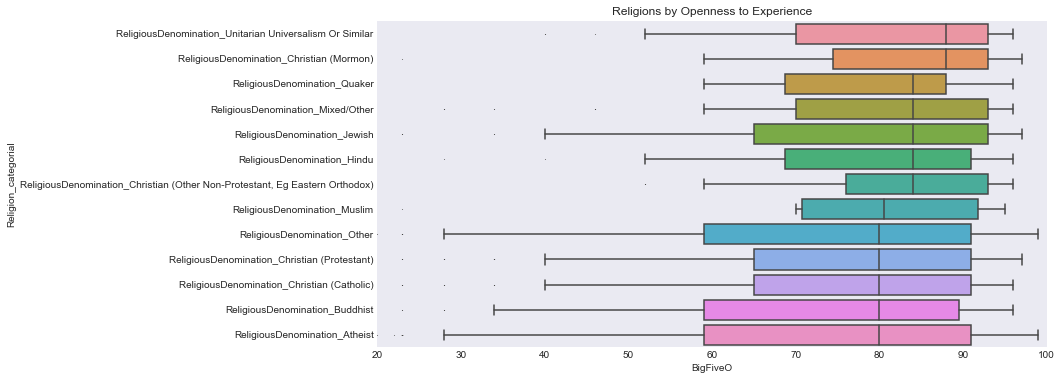

In [436]:
plt.figure(figsize=(12,6))
plt.xlim(20,100)

order = data.groupby('Religion_categorial').median()['BigFiveO'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveO'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Openness to Experience')

In [437]:
compare_top_and_bottom('BigFiveO', order)

Highest BigFiveO: ReligiousDenomination_Unitarian Universalism Or Similar
Lowest BigFiveO: ReligiousDenomination_Atheist


Ttest_indResult(statistic=2.7152239692148843, pvalue=0.0066688904204366874)

So, SSC atheists are less open than Unitarians, which isn't all that surprising. But are they less open than, say, Protestants?

In [438]:
data_o = data[data.BigFiveO.notnull()]
ttest_ind(data_o[data_o['Religion_categorial'] == 'ReligiousDenomination_Christian (Protestant)']['BigFiveO'],
          data_o[data_o['Religion_categorial'] == 'ReligiousDenomination_Atheist']['BigFiveO'])

# Answer: Yes. SSC atheists score low in openness compared to other beliefs.

Ttest_indResult(statistic=2.1880336392866266, pvalue=0.028749066130254224)

### Religions by Agreeableness

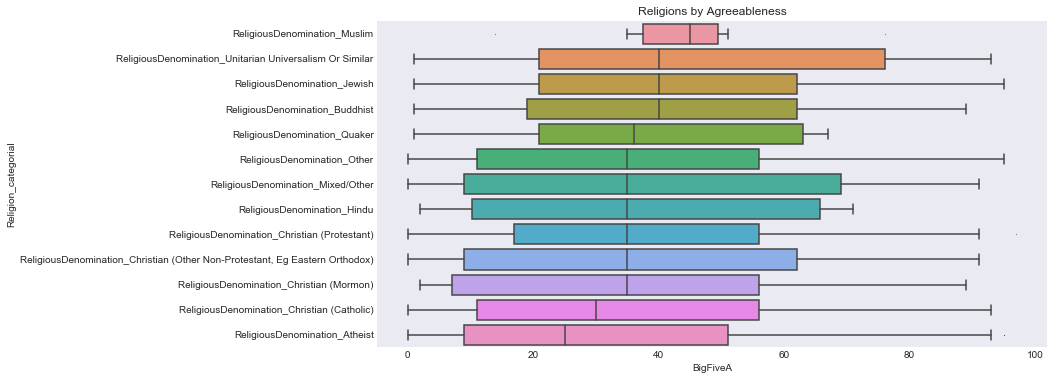

In [439]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveA'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveA'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Agreeableness')

In [441]:
compare_top_and_bottom('BigFiveA', order, top=-2)

Comparing ReligiousDenomination_Christian (Catholic) and ReligiousDenomination_Atheist


Ttest_indResult(statistic=2.0208807953734151, pvalue=0.043392675096182519)

SSC atheists are extremely disagreeable, on average. Even comparing them to the 2nd-most disagreeable group, Catholics, there's still a significant difference.

### Religions by Neuroticism

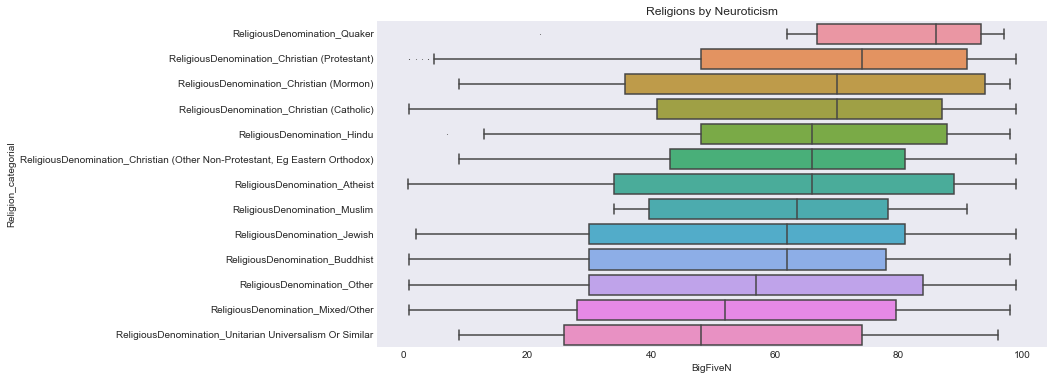

In [442]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveN'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveN'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Neuroticism')

Perhaps atheists should become Buddhist for their own mental health?

In [445]:
compare_top_and_bottom('BigFiveN', order, top=-7, bot=-4)

Comparing ReligiousDenomination_Atheist and ReligiousDenomination_Buddhist


Ttest_indResult(statistic=1.8430560324812195, pvalue=0.065438953384679296)

You could make a good argument for it. Again, I think it's weird that SSC Buddhists score low in neuroticism but also low in life satisfaction. The two should be negatively correlated.

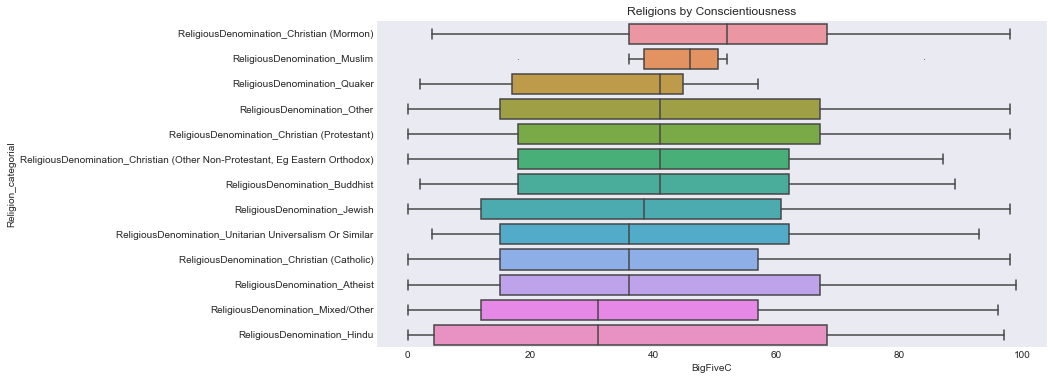

In [446]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveC'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveC'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Conscientiousness')

In [448]:
# Looks like the Mormon work ethic beats out the Protestant!
compare_top_and_bottom('BigFiveC', order, bot=4)

Comparing ReligiousDenomination_Christian (Mormon) and ReligiousDenomination_Christian (Protestant)


Ttest_indResult(statistic=1.666676460460965, pvalue=0.09635958014733155)

# Politics

In [472]:
def three_pt_scale(col):
    scale = np.zeros_like(data)
    scale = np.where(data[col] > 3, 'Favorable', np.nan)
    scale = np.where(data[col] == 3, 'Neutral', scale)
    scale = np.where(data[col] < 3, 'Unfavorable', scale)
    return pd.Series(scale[scale != 'nan'])

trump = three_pt_scale('DonaldTrump')
bernie = three_pt_scale('BernieSanders')

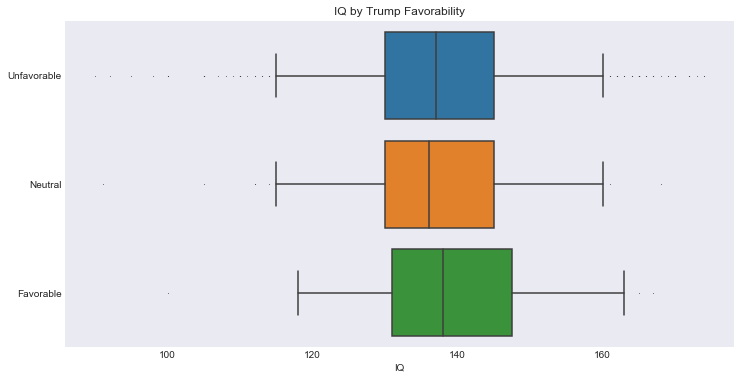

In [476]:
plt.figure(figsize=(12,6))

sns.boxplot(data['IQ'], trump, whis=1, orient='h', fliersize=.2)
plt.title('IQ by Trump Favorability')

In [484]:
data['TrumpFavorability'] = trump

data_iq = data[data.IQ.notnull()]
ttest_ind(data_iq[data_iq.TrumpFavorability == 'Favorable']['IQ'],
         data_iq[data_iq.TrumpFavorability == 'Unfavorable']['IQ'])

Ttest_indResult(statistic=1.8488017188320107, pvalue=0.064651806991960006)

In [485]:
data['BernieFavorability'] = bernie

data_iq = data[data.IQ.notnull()]
ttest_ind(data_iq[data_iq.BernieFavorability == 'Favorable']['IQ'],
         data_iq[data_iq.BernieFavorability == 'Unfavorable']['IQ'])

Ttest_indResult(statistic=1.3684855618753464, pvalue=0.17138143510670215)

SSC Trump supporters are more intelligent, on average. Go figure.

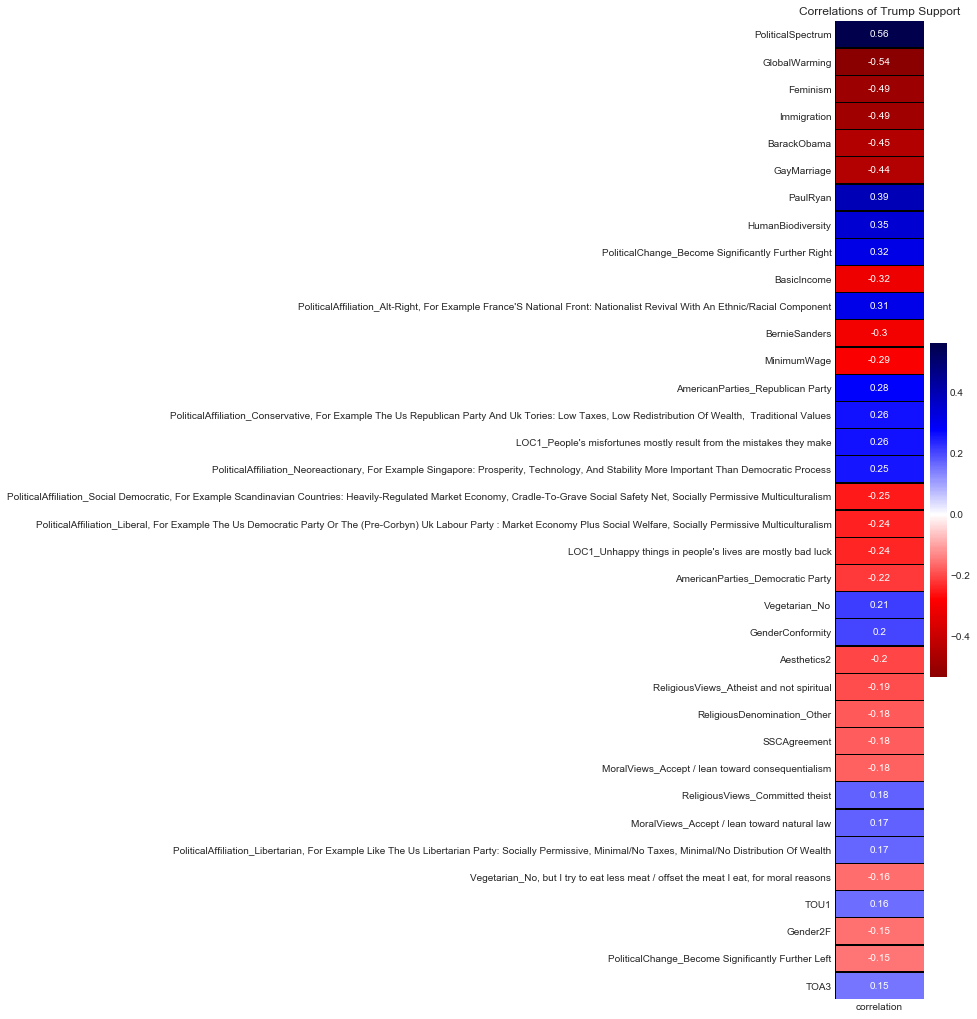

In [488]:
# Correlations of Trump Support
tr = absolute_correlations('DonaldTrump', ascending=False)
corrmap(tr, cutoff=.15, title='Correlations of Trump Support')

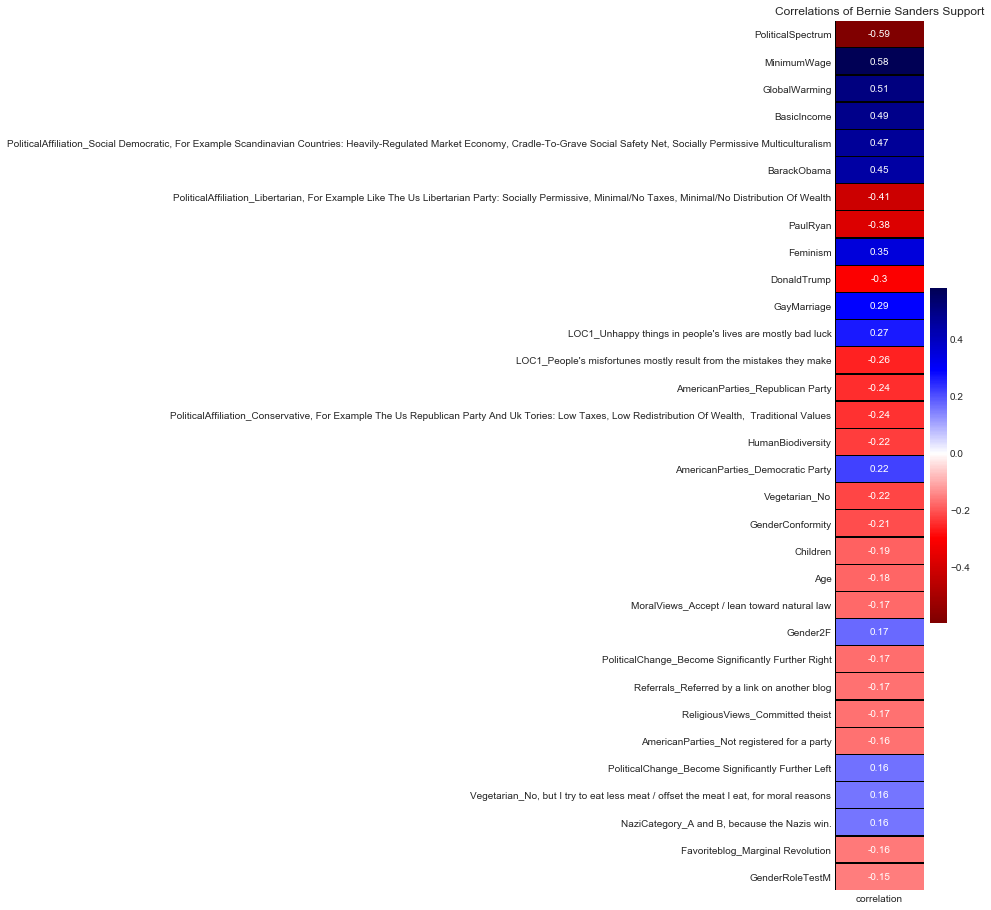

In [492]:
# Correlations of Bernie Sanders Support
bern = absolute_correlations('BernieSanders', ascending=False)
corrmap(bern, cutoff=.15, title='Correlations of Bernie Sanders Support')

In [ ]:
TODO:
    
- Correlation matrix
- Factor analysis

# Factor analysis

There's a lot of this data that's the exact opposite of what I've seen in the past -- in particular when we look at the big five personality traits. So what if we look at where SSC readers actually *do* differ? We can do this with a factor analysis.

In [622]:
# Going to use the inferred dataset again
data = pd.read_csv('ssc2018public_inferred.csv')
data = data[[i for i in data.columns if 'Favorite' not in i and 'State' not in i and 'Country' not in i]]

del data['Unnamed: 0']
del data['Timestamp']
data = data[data['CRT2'] < 100]
data = data[data['CRT1'] < 10000]
data = data[data['Gender2M'] < 300]

from sklearn.ensemble import IsolationForest
data = data.fillna(-100)
iso = IsolationForest(contamination=.05).fit(data)
data.shape

(7257, 505)

In [623]:
inliers = iso.predict(data)
data = data[inliers == 1]

data.shape

(6894, 505)

In [624]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
datamms = mms.fit_transform(data)

In [625]:
datamms = pd.DataFrame(datamms, columns=data.columns)
datamms.head()

,Age,GenderConformity,Children,ChildrenHappiness,GenderThoughts,EducationComplete,IQ,SATscoresoutof1600,SATscoresoutof2400,Percentile,...,PoliticalDisagreementI_Other,"PoliticalDisagreementI_They Might Be Right About Some Things, I Can'T Be Sure Of My Position","PoliticalDisagreementI_They Seem Pretty Wrong, And Their Mistakes Seem Incomprehensible, Some Of Them Might Be Okay, I Guess","PoliticalDisagreementI_They Seem Pretty Wrong, But They Make Understandable Mistakes And Are Probably Mostly Decent People",PoliticalDisagreementII_Inexcusably Stupid Or Downright Evil,PoliticalDisagreementII_Other,"PoliticalDisagreementII_They Might Be Right About Some Things, I Can'T Be Sure Of My Position","PoliticalDisagreementII_They Seem Pretty Wrong, And Their Mistakes Seem Incomprehensible, Some Of Them Might Be Okay, I Guess","PoliticalDisagreementII_They Seem Pretty Wrong, But They Make Understandable Mistakes And Are Probably Mostly Decent People",Relationship
0,0.294872,0.777778,0.351593,0.5,0.035225,1.0,0.119048,0.924915,0.940878,0.111111,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.192308,0.222222,0.027389,1.0,0.249619,1.0,0.738095,0.924915,0.839527,0.777778,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.192308,0.777778,0.027389,1.0,0.142422,1.0,0.642857,0.924915,1.000000,1.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.192308,0.777778,0.027389,1.0,0.035225,1.0,0.559524,0.924915,0.940878,0.888889,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.269231,0.888889,0.675796,1.0,0.035225,1.0,0.559524,0.924915,0.940878,0.444444,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [626]:
# Transpose the dataframe, so we're analyzing questions instead of users
qs = datamms.T

qs['stdev'] = qs.std(axis=1)

questions_sorted = qs.sort_values('stdev', ascending=False)['stdev'].index

# Most controversial at top; least controversial at bottom
questions_sorted

Index(['Dancer_I could make the the dancer change directions',
       'PreviousSurveys_Yes', 'PatreonI_No, don't want to',
       'HiddenOpenThreads_Yes',
       'Anxiety_I don't have this condition and neither does anyone in my family',
       'Tables_The one on the left is about 25% longer',
       'PoliticalChangeSSC_No Significant Change',
       'Discord_No, I didn't know it existed',
       'LOC1_Unhappy things in people's lives are mostly bad luck',
       'HiddenOpenThreads_No',
       ...
       'ReligiousDenomination_Taoist',
       'SSCBenefit_Introduced Me To Effective Altruism',
       'SSCBenefit_Don'T Know', 'Income', 'ReligiousBackground_Atheism',
       'SSCBenefit_Not That I Recall', 'SSCChangeMind_Effective Altruism',
       'ReligiousBackground_Anglican', 'Charity',
       'ReligiousDenomination_Polytheist'],
      dtype='object', length=505)

In [628]:
def absolute_correlations(col, df=data, threshold=.5):
    '''Finds related questions, with both positive and negative correlations'''
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs[corrs.absol > threshold].sort_values('absol', ascending=False).drop('absol', axis=1)

In [629]:
from collections import defaultdict

# Record which questions go in each factor
factors = defaultdict(list)

# Use each question only once
questions_used = []

# Put users' scores in a dataframe
df_factors = pd.DataFrame()

for question in questions_sorted:
    if question not in questions_used:
        related = absolute_correlations(
            question,
            df=datamms[[i for i in datamms.columns if i not in questions_used]],
            threshold=.50
        )        
        if len(related) >= 4:
            for related_question in related.index:
                questions_used.append(related_question)
            factors[question].append(related.index)
            
            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)   

            df_factors[question] = (datamms[pos_items].sum(axis=1) + (1-datamms[neg_items]).sum(axis=1))/(len(all_items))
            
print('found', str(df_factors.shape[1]), 'personality traits')

found 5 personality traits


In [634]:
from collections import defaultdict

# Record which questions go in each factor
factors = defaultdict(list)

# We're no longer going to worry if a question has been used
# We're now more interested in validity and reliability than style!
questions_used = []

# Put users' scores in a dataframe
df_factors = pd.DataFrame()

th = 0.50
lenrel = 4

# Seed the dataframe with the first reliable trait
for question in questions_sorted:
    related = absolute_correlations(
        question,
        df=datamms,
        threshold=th
    )        
    if len(related) >= lenrel:
        factors[question].append(related.index)

        pos_items = related[related['correlation'] > 0].index
        neg_items = related[related['correlation'] < 0].index
        all_items = list(pos_items) + list(neg_items)   

        df_factors[question] = (datamms[pos_items].sum(axis=1) + (1-datamms[neg_items]).sum(axis=1))/(len(all_items))
        break

df_factors.head()

,ReligiousDenomination_Other
0,0.75
1,0.75
2,1.00
3,0.75
4,1.00


In [635]:
corr = 0
corr_th = .5

# Run this until we find a trait that correlates more than corr_th with an existing one
while corr < corr_th:
    next_q = datamms.corrwith(df_factors[df_factors.columns[-1]])
    candidates = pd.DataFrame()
    for i in np.abs(next_q).sort_values().index:
        related = absolute_correlations(
            i,
            df=data,
            threshold=th)        
        if len(related) >= lenrel:

            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)
            candidates[i] = (datamms[pos_items].sum(axis=1) + (8-datamms[neg_items]).sum(axis=1))/(len(all_items))

    candidates_scores = {}
    for i in candidates.columns:
        candidates_scores[i] = np.abs(df_factors.corrwith(candidates[i])).max()

    candidates_scores = pd.DataFrame([candidates_scores]).T.sort_values(0)  
    corr = candidates_scores.get_value(candidates_scores.index[0], 0)
    if corr > corr_th:
        break
    print('Using:', pd.DataFrame(candidates_scores).index[0])
    print(round(corr, 2))
    
    next_q = datamms.corrwith(df_factors[df_factors.columns[-1]])
    candidates = pd.DataFrame()
    for i in candidates_scores.index:
        related = absolute_correlations(
            i,
            df=data, threshold=th)        
        if len(related) >= lenrel:
            #for related_question in related.index:
                #questions_used.append(related_question)
            factors[i].append(related.index)

            pos_items = related[related['correlation'] > 0].index
            neg_items = related[related['correlation'] < 0].index
            all_items = list(pos_items) + list(neg_items)
            df_factors[i] = (datamms[pos_items].sum(axis=1) + (8-datamms[neg_items]).sum(axis=1))/(len(all_items))    
            break
    if i == candidates_scores.index[-1]:
        raise Exception('Could not find any more traits')
    
    print()

Using: SSCChangeMind_Other
0.02

Using: Mask1_Yes
0.02

Using: Gender_F (cisgender)
0.04

Using: MinimumWage
0.16

